In [11]:
import os
import shutil
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.autograd import Variable
from PIL import Image


In [12]:
data_path = r'D:\studia mgr EIM\ZZSN\thecarconnectionpicturedataset'
listOfFiles = os.listdir(data_path)

In [13]:
# opcja 1 - rozdzielenie na typy, w car_types przechowywane nazwy plikow
source= r'D:\studia mgr EIM\ZZSN\car_picture_dataset'

car_types= ['Van','Pickup','Station Wagon','4dr','3dr','2dr','SUV','Convertible']
# reszta to 'nan'
car_dictionary = dict.fromkeys(car_types)
for type_of_car in car_types:
    str_match = [s for s in listOfFiles if type_of_car in s]
    car_dictionary[type_of_car] = str_match
    # ponizej tworzenie folderow z posortwanymi juz zdjeciami typow, czyli tzw. klas, 
    # potrzebne do ImageFolder i DataLoader

    # os.mkdir(os.path.join(source,type_of_car))
    # target_dir = os.path.join(source,type_of_car)
    # for fname in str_match:
    #     # copying the files to the destination directory
    #     shutil.copy2(os.path.join(data_path,fname), target_dir)

# ta komorka wykonuje sie ok. 5-6 min

In [14]:
# nie wiem do konca co ta komorka oznacza dla naszego kodu
# NVIDIA's CUDA Python provides a driver and runtime API
# w moim przypadku CUDA is false, czy zatem muszę jakoś specjalnie definiować obliczenia - CPU czy GPU ? mam i Intela i AMD Radeon
# TODO: ogarnac, co zrobic, pomoc 
cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [5]:
im = Image.open(r"D:\studia mgr EIM\ZZSN\car_picture_dataset\2dr\Acura_NSX_2003_89_17_250_30_6_71_46_174_17_RWD_2_2_2dr_yRp.jpg") 
im.show() 
# extract other basic metadata
info_dict = {
    "Filename": im.filename,
    "Image Size": im.size,
    "Image Height": im.height,
    "Image Width": im.width,
    "Image Format": im.format,
    "Image Mode": im.mode,
    "Image is Animated": getattr(im, "is_animated", False),
    "Frames in Image": getattr(im, "n_frames", 1)
}

for label,value in info_dict.items():
    print(f"{label:25}: {value}")

Filename                 : D:\studia mgr EIM\ZZSN\car_picture_dataset\2dr\Acura_NSX_2003_89_17_250_30_6_71_46_174_17_RWD_2_2_2dr_yRp.jpg
Image Size               : (320, 240)
Image Height             : 240
Image Width              : 320
Image Format             : JPEG
Image Mode               : RGB
Image is Animated        : False
Frames in Image          : 1


In [48]:
## inicjalizacja parametrow
number_of_classes = len(car_types)
number_of_epochs = 20

image_size_width = 320
image_size_height = 200
# na przyszlosc sprobowac dodac paski czarne by nie rozciagac zdjec
image_size=(image_size_width,image_size_height)
channels = 3 # bo RGB? czy to nie o to chodzi?
img_shape = (channels, image_size_width, image_size_height) # nie wiem, co to za parametr

batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
# Size of z latent vector (i.e. size of generator input)
latent_size = 128  # szum dla generatora

# rozmiar zdjec 320x213 pikseli, niektore na x240 lub x160 piskeli, dlatego niech bedzie 320x200 krakowskim targiem
# no chyba że musimy mieć kwadrat, jest tak podanych wiele przykladow i nie wiem, 
# czy przypadkiem wtedy nie ma siec latwiej sobie podzielic obrazu jesli oba rozmiary sa rowne

# z czego korzystam?
# 1) https://jovian.ai/tvscitechtalk/car-gan
# 2) https://github.com/ozanciga/gans-with-pytorch/blob/master/cgan/cgan.py

# ten poniżej kod bardziej do mnie przemawia jeśli chodzi o definicje dyskryminatora i generatora
# 3) https://github.com/eriklindernoren/PyTorch-GAN/blob/36d3c77e5ff20ebe0aeefd322326a134a279b93e/implementations/cgan/cgan.py#L189

train_ds = ImageFolder(source, transform=T.Compose([
    #T.Resize((image_size_width,image_size_height)),
    T.Resize((image_size_height,image_size_width)),
    T.ToTensor(),
    T.Normalize(*stats)])) # normalizacja, zeby dyskryminator mial latwiej-?

train_ds.samples = [train_ds.samples[idx] for idx in range(1000)]
train_ds.targets = [train_ds.targets[idx] for idx in range(1000)]
print(train_ds)

# TODO: czy wgl cos tu dodatkowo ustawiac? # drop_last - true or false?
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)


Dataset ImageFolder
    Number of datapoints: 1000
    Root location: D:\studia mgr EIM\ZZSN\car_picture_dataset
    StandardTransform
Transform: Compose(
               Resize(size=(200, 320), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


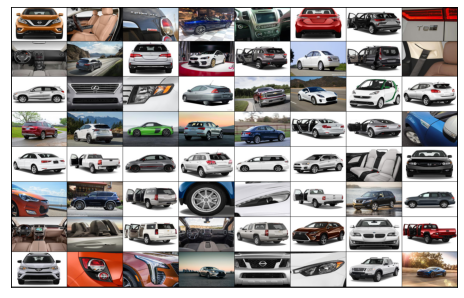

In [16]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [29]:
## klasa generatora - póki co idea skopiowana z linku 3)
# nn.Module - base class for all neural network modules
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # TODO: okreslic wlasciwe parametry w funkcji ponizej
        self.label_emb = nn.Embedding(number_of_classes, number_of_classes)

        # TODO: wypróbować Conv2d ale i sprawdzić jak zachowuje sie sieć przy nn.Linear

        def block(in_feat, out_feat, normalize=True):
                # layers = [nn.Linear(in_feat, out_feat)]
                layers = [nn.Linear(in_feat, out_feat)]
                if normalize:
                    layers.append(nn.BatchNorm1d(out_feat, 0.8))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
                return layers

        self.model = nn.Sequential(
            *block(latent_size + number_of_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

In [36]:
## klasa dyskryminatora - póki co idea skopiowana z linku 3)
class Discriminator(nn.Module):
    def __init__(self):
            super(Discriminator, self).__init__()

            self.label_embedding = nn.Embedding(number_of_classes, number_of_classes)

            # self.model = nn.Sequential(
            #     # in: 3 x 64 x 64
            #     nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            #     nn.BatchNorm2d(64),
            #     nn.LeakyReLU(0.2, inplace=True),
            #     # out: 64 x 32 x 32

            #     nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            #     nn.BatchNorm2d(128),
            #     nn.LeakyReLU(0.2, inplace=True),
            #     # out: 128 x 16 x 16

            #     nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            #     nn.BatchNorm2d(256),
            #     nn.LeakyReLU(0.2, inplace=True),
            #     # out: 256 x 8 x 8

            #     nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            #     nn.BatchNorm2d(512),
            #     nn.LeakyReLU(0.2, inplace=True),
            #     # out: 512 x 4 x 4

            #     nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            #     # out: 1 x 1 x 1

            #     nn.Flatten(),
            #     nn.Sigmoid()
            # )

            self.model = nn.Sequential(
                nn.Linear(number_of_classes+ int(np.prod(img_shape)), 512),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(512, 512),
                nn.Dropout(0.4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(512, 512),
                nn.Dropout(0.4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(512, 1),
                nn.Sigmoid()
            )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [37]:
# entropia krzyzowa 
# TODO: ustalenie parametrow

# nn.BCELoss -> binary cross entropy
# nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=- 100, 
#     reduce=None, reduction='mean', label_smoothing=0.0) -> zwykla entropia

fun_loss = nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()
b1=0.5
b2=0.999
lrate=0.0002
optimizer_D = optim.Adam(discriminator.parameters(), lr=lrate, betas=(b1, b2))
optimizer_G = optim.Adam(generator.parameters(), lr=lrate, betas=(b1, b2))

In [45]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_size))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "D:/studia mgr EIM/ZZSN/wygenerowane_zdj/%d.png" % batches_done, nrow=n_row, normalize=True)


In [49]:
# ----------
#  Training
# ----------

for epoch in range(number_of_epochs):
    for i, (imgs, labels) in enumerate(train_dl):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_size))))
        gen_labels = Variable(LongTensor(np.random.randint(0, number_of_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = fun_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = fun_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = fun_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, number_of_epochs, i, len(train_dl), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(train_dl) + i
        if batches_done % 5 == 0:
            sample_image(n_row=5, batches_done=batches_done)


[Epoch 0/20] [Batch 0/8] [D loss: 0.440457] [G loss: 0.572647]
[Epoch 0/20] [Batch 1/8] [D loss: 0.337390] [G loss: 0.966688]
[Epoch 0/20] [Batch 2/8] [D loss: 0.362119] [G loss: 0.684234]
[Epoch 0/20] [Batch 3/8] [D loss: 0.236456] [G loss: 1.088125]
[Epoch 0/20] [Batch 4/8] [D loss: 0.212013] [G loss: 1.477005]
[Epoch 0/20] [Batch 5/8] [D loss: 0.223457] [G loss: 1.056082]
[Epoch 0/20] [Batch 6/8] [D loss: 0.186470] [G loss: 1.189507]
[Epoch 0/20] [Batch 7/8] [D loss: 0.165348] [G loss: 1.520092]
[Epoch 1/20] [Batch 0/8] [D loss: 0.190346] [G loss: 1.201702]
[Epoch 1/20] [Batch 1/8] [D loss: 0.157957] [G loss: 1.387135]
[Epoch 1/20] [Batch 2/8] [D loss: 0.128963] [G loss: 1.828447]
[Epoch 1/20] [Batch 3/8] [D loss: 0.216958] [G loss: 1.133965]
[Epoch 1/20] [Batch 4/8] [D loss: 0.124517] [G loss: 1.622386]
[Epoch 1/20] [Batch 5/8] [D loss: 0.279857] [G loss: 2.136372]
[Epoch 1/20] [Batch 6/8] [D loss: 0.906791] [G loss: 0.420544]
[Epoch 1/20] [Batch 7/8] [D loss: 0.087424] [G loss: 1.

In [ ]:
# wyliczenia FID i IS jako ostatni etap